# Fraudulent Transaction Classifier
---
We try to use 3 weeks of fraud probability data to build a Machine Learning model and classify all fraudulent transactions.

### 1. Datasets
We begin by loading our dataset onto the Jupyter Notebook and make our `fraud_probability` column

In [75]:
from pyspark.sql import SparkSession, Window, functions as F

# Create a spark session
spark = (
    SparkSession.builder.appName("BNPL Project")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "8g")
    .config("spark.driver.executor", "8g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

p = lambda x,type : f'../../data/{type}/{x}'

In [76]:
sdf = spark.read.parquet(p('process_data.parquet', 'curated'), header=True)

# Create Joint Probability of Fraud Transactions
sdf = sdf.withColumn('fraud_probability', F.col('user_fraud_probability') * F.col('merchant_fraud_probability'))
sdf.limit(10)

merchant_abn,consumer_id,user_id,dollar_value,order_id,order_datetime,state,postcode,gender,merchant_name,tag,revenue,rate,category,subcategory,merchant_fraud_probability,user_fraud_probability,estimated_region_population_2021_sum,persons_earners_2018-19_sum,mean_earnings_2018-19_avg,sum_earnings_2018-19_sum,median_earnings_2018-19_avg,med_age_earners_2018-19_avg,fraud_probability
27093785141,1195503,1,366.23,a8514aae-18fb-454...,2021-11-17,WA,6935,Female,Placerat Orci Ins...,"stationery, offic...",c,2.73,retail_and_wholes...,others_retailing,0.29407407407407304,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,0.029407407407407306
49125619545,1195503,1,113.59,8dce56c3-1138-45b...,2022-06-28,WA,6935,Female,Adipiscing Elit C...,"cable, satellite,...",a,5.66,info_media_and_te...,null,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,null
28510201393,1195503,1,587.4,32fcbb45-ae51-42f...,2021-09-24,WA,6935,Female,Quam Curabitur Co...,bicycle shops - s...,c,1.86,retail_and_wholes...,department_stores,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,null
49167531725,1195503,1,51.58,7080c274-17f7-4cc...,2021-11-26,WA,6935,Female,Felis Institute,digital goods: bo...,a,6.42,retail_and_wholes...,household_goods_r...,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,null
43719937438,1195503,1,196.41,7f2a0fc6-6255-4f5...,2022-05-22,WA,6935,Female,Class Aptent Taci...,"cable, satellite,...",b,5.01,info_media_and_te...,null,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,null
49278214714,1195503,1,7.84,624a43e1-e583-47e...,2022-08-10,WA,6935,Female,Augue Malesuada LLP,digital goods: bo...,a,5.99,retail_and_wholes...,household_goods_r...,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,null
46007761675,1195503,1,100.22,036e4012-7e3b-4cf...,2022-10-24,WA,6935,Female,Est Nunc Ullamcor...,"computers, comput...",a,5.72,retail_and_wholes...,household_goods_r...,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,null
50315283629,1195503,1,115.82,15aa1064-944f-4e5...,2021-11-13,WA,6935,Female,Iaculis Aliquet D...,lawn and garden s...,c,1.76,retail_and_wholes...,food_retailing,0.28488372093023295,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,0.028488372093023295
46654841462,1195503,1,18.5,b661e2cb-0796-444...,2022-09-03,WA,6935,Female,Iaculis Enim Corp.,"equipment, tool, ...",b,3.81,rental_hiring_and...,null,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,null
50315283629,1195503,1,63.88,c4e1da7a-39b5-49d...,2022-10-13,WA,6935,Female,Iaculis Aliquet D...,lawn and garden s...,c,1.76,retail_and_wholes...,food_retailing,0.28488372093023295,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,0.028488372093023295


In [77]:
print('missing user_fraud_probability count:', sdf.where(F.col('user_fraud_probability').isNull()).count())
print('missing merchant_fraud_probability count:', sdf.where(F.col('merchant_fraud_probability').isNull()).count())

missing user_fraud_probability count: 2581301
missing merchant_fraud_probability count: 13030611


array([[<AxesSubplot:title={'center':'user_fraud_probability'}>]],
      dtype=object)

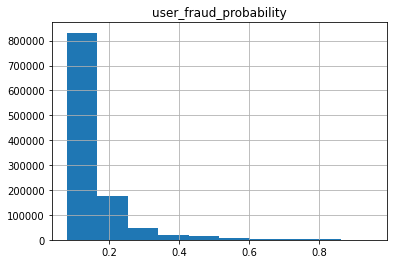

In [78]:
sdf.select(F.col('user_fraud_probability')).sample(0.1).toPandas().hist()

array([[<AxesSubplot:title={'center':'merchant_fraud_probability'}>]],
      dtype=object)

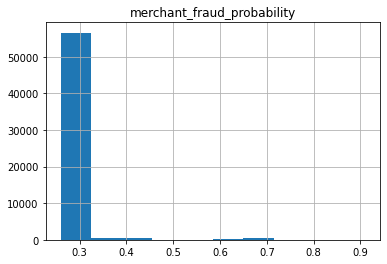

In [79]:
sdf.select(F.col('merchant_fraud_probability')).sample(0.1).toPandas().hist()

array([[<AxesSubplot:title={'center':'fraud_probability'}>]], dtype=object)

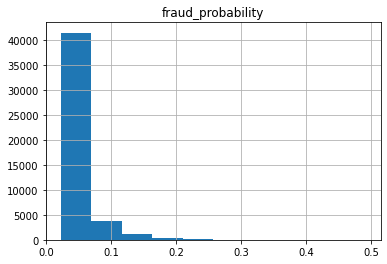

In [80]:
sdf.select(F.col('fraud_probability')).sample(0.1).toPandas().hist()

<AxesSubplot:ylabel='Frequency'>

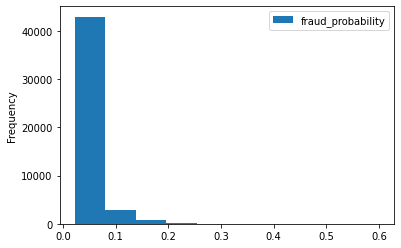

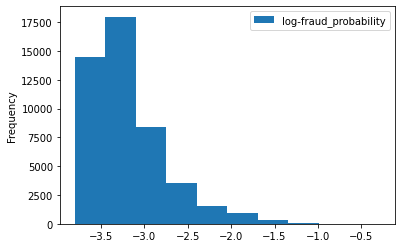

In [81]:
from math import log

sdf.select(F.col('fraud_probability')).sample(0.1).toPandas().plot(kind='hist')
sdf.select(F.col('fraud_probability')).sample(0.1).toPandas()\
    .applymap(log)\
    .rename({'fraud_probability': 'log-fraud_probability'}, axis=1)\
    .plot(kind='hist')

### 2. Modelling
We will use a specific predictors to help train the fraud detector.

In [82]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer

In [83]:
features = ['merchant_abn',
    'user_id',
    'dollar_value',
    'state',
    'postcode',
    'gender',
    'tag',
    'revenue',
    'rate',
    'category',
    'subcategory',
    'merchant_fraud_probability',
    'user_fraud_probability',
    'estimated_region_population_2021_sum',
    'persons_earners_2018-19_sum',
    'mean_earnings_2018-19_avg',
    'sum_earnings_2018-19_sum',
    'median_earnings_2018-19_avg',
    'med_age_earners_2018-19_avg']

label = 'fraud_probability'

In [84]:
categorical = ['postcode', 'state', 'merchant_abn', 'user_id', 'revenue', 'gender', 'tag', 'category', 'subcategory']

for c in categorical:
    v = StringIndexer(inputCol=c, outputCol=f'{c}_i', handleInvalid='skip')
    model = v.fit(sdf)
    sdf = model.transform(sdf).drop(c).withColumnRenamed(f'{c}_i', c)


22/09/22 13:10:02 WARN DAGScheduler: Broadcasting large task binary with size 1007.6 KiB


22/09/22 13:10:05 WARN DAGScheduler: Broadcasting large task binary with size 1001.5 KiB
22/09/22 13:10:05 WARN DAGScheduler: Broadcasting large task binary with size 1011.9 KiB


22/09/22 13:10:08 WARN DAGScheduler: Broadcasting large task binary with size 1004.7 KiB
22/09/22 13:10:08 WARN DAGScheduler: Broadcasting large task binary with size 1016.2 KiB


22/09/22 13:10:12 WARN DAGScheduler: Broadcasting large task binary with size 1007.8 KiB
22/09/22 13:10:12 WARN DAGScheduler: Broadcasting large task binary with size 1022.0 KiB


22/09/22 13:10:16 WARN DAGScheduler: Broadcasting large task binary with size 1012.4 KiB
22/09/22 13:10:16 WARN DAGScheduler: Broadcasting large task binary with size 1026.4 KiB


22/09/22 13:10:20 WARN DAGScheduler: Broadcasting large task binary with size 1015.7 KiB


In [85]:
features_model = VectorAssembler(inputCols=features, outputCol='features', handleInvalid='keep')
sdf = features_model.transform(sdf)

In [88]:
sdf = sdf.withColumn('label', F.when(F.col('fraud_probability') > 0.25, 1).otherwise(0))
sdf

22/09/22 13:12:38 WARN DAGScheduler: Broadcasting large task binary with size 1220.5 KiB
22/09/22 13:12:38 WARN DAGScheduler: Broadcasting large task binary with size 1220.5 KiB


consumer_id,dollar_value,order_id,order_datetime,merchant_name,rate,merchant_fraud_probability,user_fraud_probability,estimated_region_population_2021_sum,persons_earners_2018-19_sum,mean_earnings_2018-19_avg,sum_earnings_2018-19_sum,median_earnings_2018-19_avg,med_age_earners_2018-19_avg,fraud_probability,postcode,state,merchant_abn,user_id,revenue,gender,tag,category,subcategory,features,label
1195503,366.23,a8514aae-18fb-454...,2021-11-17,Placerat Orci Ins...,2.73,0.29407407407407304,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,0.029407407407407306,169.0,2.0,87.0,20960.0,2.0,1.0,20.0,0.0,2.0,"[87.0,20960.0,366...",0
1195503,587.4,32fcbb45-ae51-42f...,2021-09-24,Quam Curabitur Co...,1.86,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,null,169.0,2.0,1365.0,20960.0,2.0,1.0,18.0,0.0,0.0,"[1365.0,20960.0,5...",0
1195503,51.58,7080c274-17f7-4cc...,2021-11-26,Felis Institute,6.42,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,null,169.0,2.0,800.0,20960.0,0.0,1.0,2.0,0.0,1.0,"[800.0,20960.0,51...",0
1195503,7.84,624a43e1-e583-47e...,2022-08-10,Augue Malesuada LLP,5.99,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,null,169.0,2.0,368.0,20960.0,0.0,1.0,2.0,0.0,1.0,"[368.0,20960.0,7....",0
1195503,100.22,036e4012-7e3b-4cf...,2022-10-24,Est Nunc Ullamcor...,5.72,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,null,169.0,2.0,1716.0,20960.0,0.0,1.0,7.0,0.0,1.0,"[1716.0,20960.0,1...",0
1195503,115.82,15aa1064-944f-4e5...,2021-11-13,Iaculis Aliquet D...,1.76,0.28488372093023295,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,0.028488372093023295,169.0,2.0,67.0,20960.0,2.0,1.0,13.0,0.0,4.0,"[67.0,20960.0,115...",0
1195503,63.88,c4e1da7a-39b5-49d...,2022-10-13,Iaculis Aliquet D...,1.76,0.28488372093023295,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,0.028488372093023295,169.0,2.0,67.0,20960.0,2.0,1.0,13.0,0.0,4.0,"[67.0,20960.0,63....",0
1195503,75.96,2acb5626-c669-42f...,2021-09-24,Ut Tincidunt Foun...,6.3,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,null,169.0,2.0,430.0,20960.0,0.0,1.0,6.0,0.0,2.0,"[430.0,20960.0,75...",0
1195503,22.37,6bf06960-078c-410...,2021-10-02,Dis Parturient Mo...,6.26,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,null,169.0,2.0,788.0,20960.0,0.0,1.0,19.0,0.0,0.0,"[788.0,20960.0,22...",0
1195503,49.1,fe9ad64b-9ab5-48b...,2022-04-27,Lacus Quisque Imp...,3.52,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,null,169.0,2.0,2519.0,20960.0,1.0,1.0,2.0,0.0,1.0,"[2519.0,20960.0,4...",0


We will train the model on both label 1 and label 2

In [92]:
sdf.limit(1)

22/09/22 13:14:41 WARN DAGScheduler: Broadcasting large task binary with size 1228.2 KiB
22/09/22 13:14:41 WARN DAGScheduler: Broadcasting large task binary with size 1228.2 KiB


consumer_id,dollar_value,order_id,order_datetime,merchant_name,rate,merchant_fraud_probability,user_fraud_probability,estimated_region_population_2021_sum,persons_earners_2018-19_sum,mean_earnings_2018-19_avg,sum_earnings_2018-19_sum,median_earnings_2018-19_avg,med_age_earners_2018-19_avg,fraud_probability,postcode,state,merchant_abn,user_id,revenue,gender,tag,category,subcategory,features,label
1195503,366.23,a8514aae-18fb-454...,2021-11-17,Placerat Orci Ins...,2.73,0.29407407407407304,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,0.029407407407407306,169.0,2.0,87.0,20960.0,2.0,1.0,20.0,0.0,2.0,"[87.0,20960.0,366...",0


In [93]:
LR = LogisticRegression(featuresCol='features', labelCol='label', predictionCol='prediction')
model = LR.fit(sdf)
sdf = model.transform(sdf)
sdf 

22/09/22 13:15:30 WARN DAGScheduler: Broadcasting large task binary with size 1247.6 KiB


22/09/22 13:15:47 WARN DAGScheduler: Broadcasting large task binary with size 1248.8 KiB
22/09/22 13:15:47 WARN DAGScheduler: Broadcasting large task binary with size 1249.2 KiB


22/09/22 13:16:04 WARN DAGScheduler: Broadcasting large task binary with size 1250.3 KiB
22/09/22 13:16:04 ERROR Instrumentation: java.lang.IllegalArgumentException: requirement failed: init value should <= bound
	at scala.Predef$.require(Predef.scala:281)
	at breeze.optimize.StrongWolfeLineSearch.minimizeWithBound(StrongWolfe.scala:73)
	at breeze.optimize.StrongWolfeLineSearch.minimize(StrongWolfe.scala:62)
	at breeze.optimize.LBFGS.determineStepSize(LBFGS.scala:82)
	at breeze.optimize.LBFGS.determineStepSize(LBFGS.scala:38)
	at breeze.optimize.FirstOrderMinimizer.$anonfun$infiniteIterations$1(FirstOrderMinimizer.scala:60)
	at scala.collection.Iterator$$anon$7.next(Iterator.scala:140)
	at breeze.util.IteratorImplicits$RichIterator$$anon$2.next(Implicits.scala:74)
	at org.apache.spark.ml.classification.LogisticRegression.trainImpl(LogisticRegression.scala:1010)
	at org.apache.spark.ml.classification.LogisticRegression.$anonfun$train$1(LogisticRegression.scala:629)
	at org.apache.spark.

IllegalArgumentException: requirement failed: init value should <= bound